<a href="https://colab.research.google.com/github/KodumuruRaja/IMBalanced-Balanced-data/blob/main/Cluster-Based-Over-Sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install clover

In [ ]:
pip install cluster-over-sampling


Clustering-based over-sampling
This example illustrates the data generation 
process and the performance of various 
over-samplers when clustering-based over-sampling 
is used.



AttributeError: ignored

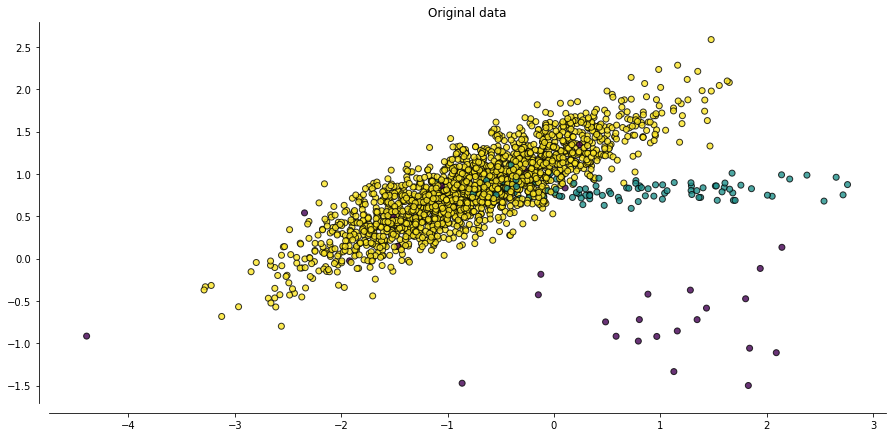

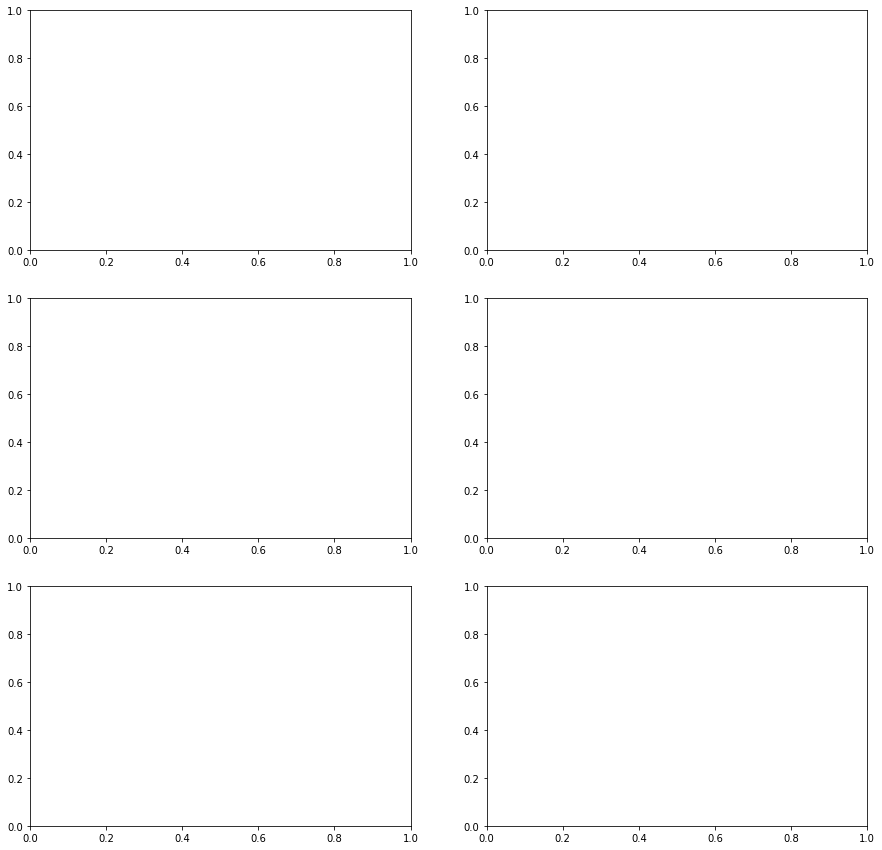

In [ ]:
"""
==============================
Clustering-based over-sampling
==============================
This example illustrates the data generation 
process and the performance of various 
over-samplers when clustering-based over-sampling 
is used.
"""

# Author: Georgios Douzas <gdouzas@icloud.com>
# Licence: MIT

import matplotlib.pyplot as plt

import pandas as pd
from sklearn.base import clone
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE
from imblearn.pipeline import make_pipeline

from clover.over_sampling import ClusterOverSampler

print(__doc__)

RANDOM_STATE = 0
OVERSAMPLERS = [
    RandomOverSampler(random_state=RANDOM_STATE),
    SMOTE(random_state=RANDOM_STATE + 1),
    BorderlineSMOTE(random_state=RANDOM_STATE + 2),
]
KMEANS = KMeans(random_state=RANDOM_STATE, n_clusters=100)


def generate_imbalanced_data():
    """Generate imbalanced data."""
    X, y = make_classification(
        n_classes=3,
        class_sep=0.8,
        weights=[0.01, 0.05, 0.94],
        n_informative=2,
        n_redundant=0,
        n_repeated=0,
        n_features=2,
        n_clusters_per_class=1,
        n_samples=2000,
        random_state=RANDOM_STATE,
    )
    return X, y


def plot_data(X, y, oversampler, ax):
    """Plot original or resampled data."""
    if oversampler is None:
        X_res, y_res = X, y
        title = 'Original data'
    else:
        oversampler = clone(oversampler)
        X_res, y_res = oversampler.fit_resample(X, y)
        if not isinstance(oversampler, ClusterOverSampler):
            ovs_name = oversampler.__class__.__name__
            title = f'Resampling using {ovs_name}'
        else:
            clusterer_name = oversampler.clusterer.__class__.__name__
            ovs_name = oversampler.oversampler_.__class__.__name__
            title = f'Resampling using {clusterer_name}-{ovs_name}'
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_title(title)


def compare_f1_scores(X_train, X_test, y_train, y_test, clf, oversampler, clusterer):
    """Compare F1 scores of oversamplers with and 
    without clustering."""
    ovs_clf = make_pipeline(clone(oversampler), clf)
    clr_ovs_clf = make_pipeline(ClusterOverSampler(clone(oversampler), clusterer), clf)
    y_pred = ovs_clf.fit(X_train, y_train).predict(X_test)
    y_pred_clr = clr_ovs_clf.fit(X_train, y_train).predict(X_test)
    ovs_name = oversampler.__class__.__name__
    clr_name = clusterer.__class__.__name__
    ovs_score = f1_score(y_test, y_pred, average='macro')
    clr_ovs_score = f1_score(y_test, y_pred_clr, average='macro')
    return pd.DataFrame(
        [[ovs_score, clr_ovs_score]],
        columns=['No clustering', clr_name],
        index=[ovs_name],
    )


###############################################################################
# Generate imbalanced data
###############################################################################

###############################################################################
# We are generating a highly imbalanced multi-class data set, using
# ``make_classification`` from scikit-learn.

X, y = generate_imbalanced_data()
_, ax = plt.subplots(1, 1, figsize=(15, 7))
plot_data(X, y, None, ax)

###############################################################################
# Effect of clustering to over-samplers
###############################################################################

###############################################################################
# Clustering based over-sampling allows to identify areas of the input space
# which are appropriate to generate artificial data. Therefore, the generation
# of noisy samples is avoided and the within-classes imbalanced issue is also
# addressed. The next plots show the resampled data when clustering is applied,
# comparing them to the resampled data of the initial over-samplers.

fig, axs = plt.subplots(3, 2, figsize=(15, 15))
for (ax1, ax2), oversampler in zip(axs, OVERSAMPLERS):
    plot_data(X, y, clone(oversampler), ax1)
    plot_data(X, y, ClusterOverSampler(oversampler, KMEANS), ax2)
fig.tight_layout()

###############################################################################
# Performance evaluation of clustering based over-sampling
###############################################################################

###############################################################################
# We are evaluating various over-samplers using F1-score as evaluation metric
# on a test set. The scores with and without clustering are compared.

clf = GradientBoostingClassifier(random_state=RANDOM_STATE)
data = train_test_split(X, y, random_state=RANDOM_STATE)
scores = pd.DataFrame()
for oversampler in OVERSAMPLERS:
    scores = scores.append(compare_f1_scores(*data, clf, oversampler, KMEANS))
print(scores)

###############################################################################
# We repeat the process for AgglomerativeClustering instead of KMeans.

aff_prop = AgglomerativeClustering(n_clusters=100)
scores = pd.DataFrame()
for oversampler in OVERSAMPLERS:
    scores = scores.append(compare_f1_scores(*data, clf, oversampler, aff_prop))
print(scores)